In [111]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import backtrader as bt
from typing import Tuple, List
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [112]:
price_path   = r'C:\Users\Leo Hubmann\Desktop\thesis\data\price_data\bitcoin_2021_2024.csv'
vader_path   = r'C:\Users\Leo Hubmann\Desktop\BachelorThesis_data\all_daily_vader_sentiment_v2.csv'
finbert_path = r'C:\Users\Leo Hubmann\Desktop\BachelorThesis_data\all_daily_finbert_sentiment_v4.csv'

In [113]:
price = (pd.read_csv(price_path,   parse_dates=['date'], low_memory=False)
         .set_index('date')
         .loc['2020-12-31':'2024-12-31', 'close'])

In [114]:
vader = (pd.read_csv(vader_path,   parse_dates=['date'], low_memory=False)
        .set_index('date')['daily_vader_sentiment'])

In [115]:
finbert = (pd.read_csv(finbert_path, parse_dates=['date'], low_memory=False)
        .set_index('date')['daily_finbert_score'])

In [116]:
df = pd.concat({'close': price, 'vader': vader, 'finbert': finbert}, axis=1)

In [117]:
# compute log returns
df['ret'] = np.log(df['close']).diff()
df = df.dropna()

In [119]:
ROLL_Z = 90     # rolling z-score window

# rolling standardisation (finbert and vader do not have the same scale)
roll_mean_v = vader.rolling(ROLL_Z).mean()
roll_std_v  = vader.rolling(ROLL_Z).std()

roll_mean_f = finbert.rolling(ROLL_Z).mean()
roll_std_f  = finbert.rolling(ROLL_Z).std()

df['vader_z']   = (df['vader']   - roll_mean_v) / roll_std_v
df['finbert_z'] = (df['finbert'] - roll_mean_f) / roll_std_f

In [120]:
# df['vader_z']   = df['vader_z'].clip(lower=-3, upper=3)
# df['finbert_z'] = df['finbert_z'].clip(lower=-3, upper=3)

In [121]:
df[['vader_z', 'finbert_z']].describe()

,vader_z,finbert_z
count,1372.000000,1372.000000
mean,-0.021347,-0.022083
std,1.061312,1.054883
min,-4.720014,-3.094124
25%,-0.679890,-0.804048
50%,0.028530,-0.037667
75%,0.689570,0.672782
max,7.239749,5.019495


## Strategy 2.A: Vader

In [122]:
# params
TRAIN_END   = '2023-12-31'     # IS / OOS split
ROLL_PCT    = 60               # window for percentile thresholds
TH_UP, TH_DN = 0.75, 0.25      # 75th / 25th percentiles
TC          = 0.001            # 0.10 % round-trip cost
EMA_GRID    = range(3, 11)     # spans to test (3…10)


In [123]:
# functions for the necessary metrics

SHARPE_DAYS = 365          # 365 for crypto

# annual sharpe, but with rf = 0
def ann_sharpe(ret: pd.Series) -> float:
    return np.sqrt(SHARPE_DAYS) * ret.mean() / ret.std()

def cum_curve(ret: pd.Series) -> pd.Series:
    """Cumulative growth of 1 unit."""
    return np.exp(ret.cumsum())

def max_drawdown(ret: pd.Series) -> float:
    r   = ret.fillna(0)            # ← ①  replace first NaN by 0-return
    eq  = np.exp(r.cumsum())       # cumulative equity
    roll_max = np.maximum.accumulate(eq)
    dd  = 1 - eq / roll_max
    return dd.max()


In [124]:
# strategy function
def build_strategy(df_in: pd.DataFrame, ema_span: int,
                   return_alloc: bool = False):
    """
    Build Strategy A and return daily returns
    """
    d = df_in.copy()

    # 1) Smooth sentiment
    d['sent_ema'] = d['vader_z'].ewm(span=ema_span, adjust=False).mean()

    # 2) Adaptive thresholds
    p75 = d['sent_ema'].rolling(ROLL_PCT).quantile(TH_UP)
    p25 = d['sent_ema'].rolling(ROLL_PCT).quantile(TH_DN)

    # 3) Regime classification → allocation
    d['regime'] = np.where(d['sent_ema'] > p75, 'bull',
                           np.where(d['sent_ema'] < p25, 'bear', 'neutral'))
    alloc_map = {'bull': 1.0, 'neutral': 0.1, 'bear': 0.0}
    d['alloc_daily'] = d['regime'].map(alloc_map)

    # 4) Weekly rebal (Monday close)
    d['alloc'] = (d['alloc_daily']
                  .resample('W-MON')
                  .first()
                  .reindex(d.index, method='ffill'))

    # 5) Strategy returns with TC
    alloc_prev = d['alloc'].shift()
    tc = np.abs(d['alloc'] - alloc_prev) * TC
    strat_ret = alloc_prev * d['ret'] - tc.fillna(0)

    if return_alloc:
        return strat_ret, d['alloc']
    return strat_ret

In [125]:
# hyper param optimization (refer to BI lecture?) GRID-SEARCH  (find EMA span on 2021-23 data to avoid look-ahead)
is_mask = df.index <= TRAIN_END
grid_results: List[Tuple[int, float]] = []

for span in EMA_GRID:
    r   = build_strategy(df, span)
    sh  = ann_sharpe(r[is_mask])
    grid_results.append((span, sh))

best_span, best_sh    = max(grid_results, key=lambda x: x[1])
print(f'Best EMA span (IS 2021-23) = {best_span}   |  Sharpe = {best_sh:.2f}')

Best EMA span (IS 2021-23) = 3   |  Sharpe = 0.37



=== Quick performance check ===
IS  Sharpe: 0.37
OOS Sharpe: 1.71


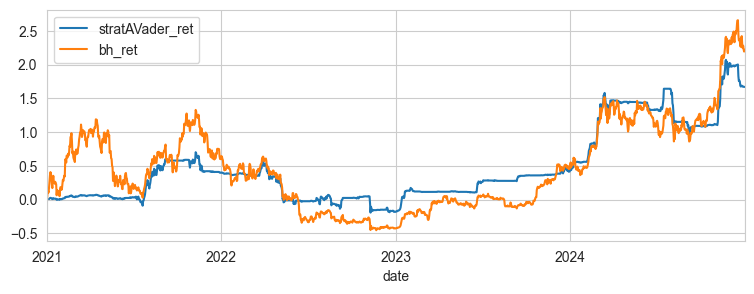

In [126]:
# strategy exec
df['stratAVader_ret'] = build_strategy(df, best_span)
df['bh_ret']    = df['ret']                     # buy-and-hold benchmark

oos_mask        = df.index > TRAIN_END

print('\n=== Quick performance check ===')
print('IS  Sharpe:', ann_sharpe(df['stratAVader_ret'][is_mask]).round(2))
print('OOS Sharpe:', ann_sharpe(df['stratAVader_ret'][oos_mask]).round(2))

# cum performance (lol)
(np.exp(df[['stratAVader_ret','bh_ret']].cumsum()) - 1).plot(figsize=(9,3));

Full                IS               OOS         
          Strategy Buy&Hold Strategy Buy&Hold Strategy Buy&Hold
Total Ret     1.67     2.22     0.42     0.46     0.88     1.21
Ann Vol       0.33     0.62     0.31     0.65     0.37     0.53
Sharpe        0.75     0.47     0.37     0.19     1.71     1.49
Max DD        0.53     0.77     0.53     0.77     0.26     0.26

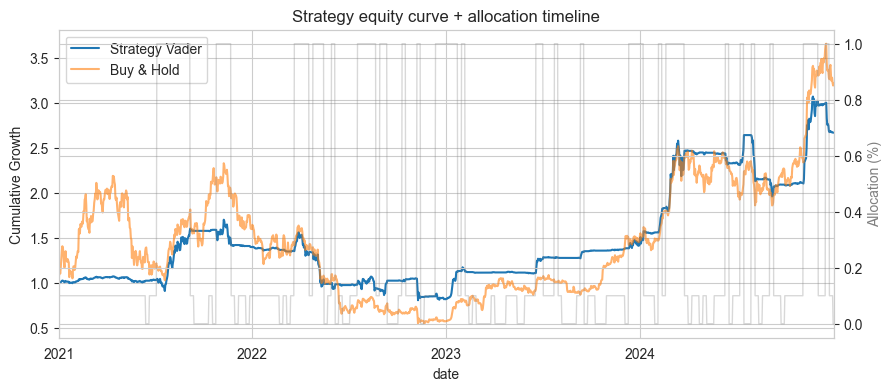

In [127]:
# single code block, directly with frozen ema

df['stratAVader_ret'], df['alloc'] = build_strategy(df, best_span, return_alloc=True)
df['bh_ret'] = df['ret']

# performance table
def stats(label, r):
    return pd.Series({
        'Total Ret': cum_curve(r).iloc[-1] - 1,
        'Ann Vol': r.std()*np.sqrt(SHARPE_DAYS),
        'Sharpe': ann_sharpe(r),
        'Max DD': max_drawdown(r)
    }, name=label)

is_mask  = df.index <= TRAIN_END
oos_mask = df.index >  TRAIN_END

table = pd.concat({
    'Full':  pd.concat([stats('Strategy', df['stratAVader_ret']),
                        stats('Buy&Hold', df['bh_ret'])], axis=1),
    'IS':    pd.concat([stats('Strategy', df.loc[is_mask, 'stratAVader_ret']),
                        stats('Buy&Hold', df.loc[is_mask, 'bh_ret'])], axis=1),
    'OOS':   pd.concat([stats('Strategy', df.loc[oos_mask, 'stratAVader_ret']),
                        stats('Buy&Hold', df.loc[oos_mask, 'bh_ret'])], axis=1)
}, axis=1).round(2)

display(table)

# equity + alloc overlay
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10,4))
cum_curve(df['stratAVader_ret']).plot(ax=ax1, label='Strategy Vader')
cum_curve(df['bh_ret']).plot(ax=ax1, label='Buy & Hold', alpha=.6)
ax1.set_ylabel('Cumulative Growth')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
df['alloc'].plot(ax=ax2, color='grey', alpha=.3, linewidth=1)
ax2.set_ylabel('Allocation (%)', color='grey')
ax2.set_ylim(-0.05,1.05)
plt.title('Strategy equity curve + allocation timeline')
plt.show()

## Strategy 2.B: FinBERT

In [128]:
TRAIN_END   = '2023-12-31'     # IS / OOS split
ROLL_PCT    = 60               # window for percentile thresholds
TH_UP, TH_DN = 0.75, 0.25      # 75th / 25th percentiles
TC          = 0.001            # 0.10 % round-trip cost
EMA_GRID    = range(3, 11)     # spans to test (3…10)

In [129]:
# functions for the necessary metrics

SHARPE_DAYS = 365          # 365 for crypto

# annual sharpe, but with rf = 0
def ann_sharpe(ret: pd.Series) -> float:
    return np.sqrt(SHARPE_DAYS) * ret.mean() / ret.std()

def cum_curve(ret: pd.Series) -> pd.Series:
    """Cumulative growth of 1 unit."""
    return np.exp(ret.cumsum())

def max_drawdown(ret: pd.Series) -> float:
    r   = ret.fillna(0)            # ← ①  replace first NaN by 0-return
    eq  = np.exp(r.cumsum())       # cumulative equity
    roll_max = np.maximum.accumulate(eq)
    dd  = 1 - eq / roll_max
    return dd.max()


In [130]:
# strategy function
def build_strategy(df_in: pd.DataFrame, ema_span: int,
                   return_alloc: bool = False):
    """
    Build Strategy A and return daily returns
    """
    d = df_in.copy()

    # 1) Smooth sentiment
    d['sent_ema'] = d['finbert_z'].ewm(span=ema_span, adjust=False).mean()

    # 2) Adaptive thresholds
    p75 = d['sent_ema'].rolling(ROLL_PCT).quantile(TH_UP)
    p25 = d['sent_ema'].rolling(ROLL_PCT).quantile(TH_DN)

    # 3) Regime classification → allocation
    d['regime'] = np.where(d['sent_ema'] > p75, 'bull',
                           np.where(d['sent_ema'] < p25, 'bear', 'neutral'))
    alloc_map = {'bull': 1.0, 'neutral': 0.1, 'bear': 0.0}
    d['alloc_daily'] = d['regime'].map(alloc_map)

    # 4) Weekly rebal (Monday close)
    d['alloc'] = (d['alloc_daily']
                  .resample('W-MON')
                  .first()
                  .reindex(d.index, method='ffill'))

    # 5) Strategy returns with TC
    alloc_prev = d['alloc'].shift()
    tc = np.abs(d['alloc'] - alloc_prev) * TC
    strat_ret = alloc_prev * d['ret'] - tc.fillna(0)

    if return_alloc:
        return strat_ret, d['alloc']
    return strat_ret

In [131]:
# hyper param optimization (refer to BI lecture?) GRID-SEARCH  (find EMA span on 2021-23 data to avoid look-ahead)
is_mask = df.index <= TRAIN_END
grid_results: List[Tuple[int, float]] = []

for span in EMA_GRID:
    r   = build_strategy(df, span)
    sh  = ann_sharpe(r[is_mask])
    grid_results.append((span, sh))

best_span, best_sh    = max(grid_results, key=lambda x: x[1])
print(f'Best EMA span (IS 2021-23) = {best_span}   |  Sharpe = {best_sh:.2f}')

Best EMA span (IS 2021-23) = 10   |  Sharpe = 0.07



=== Quick performance check ===
IS  Sharpe: 0.07
OOS Sharpe: 2.03


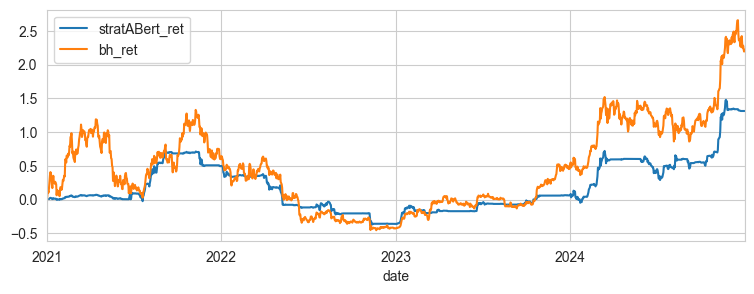

In [132]:
# strategy exec
df['stratABert_ret'] = build_strategy(df, best_span)
df['bh_ret']    = df['ret']                     # buy-and-hold benchmark

oos_mask        = df.index > TRAIN_END

print('\n=== Quick performance check ===')
print('IS  Sharpe:', ann_sharpe(df['stratABert_ret'][is_mask]).round(2))
print('OOS Sharpe:', ann_sharpe(df['stratABert_ret'][oos_mask]).round(2))

# cum performance (lol)
(np.exp(df[['stratABert_ret','bh_ret']].cumsum()) - 1).plot(figsize=(9,3));

Full                IS               OOS         
          Strategy Buy&Hold Strategy Buy&Hold Strategy Buy&Hold
Total Ret     1.31     2.22     0.06     0.46     1.18     1.21
Ann Vol       0.32     0.62     0.29     0.65     0.38     0.53
Sharpe        0.66     0.47     0.07     0.19     2.03     1.49
Max DD        0.64     0.77     0.64     0.77     0.25     0.26

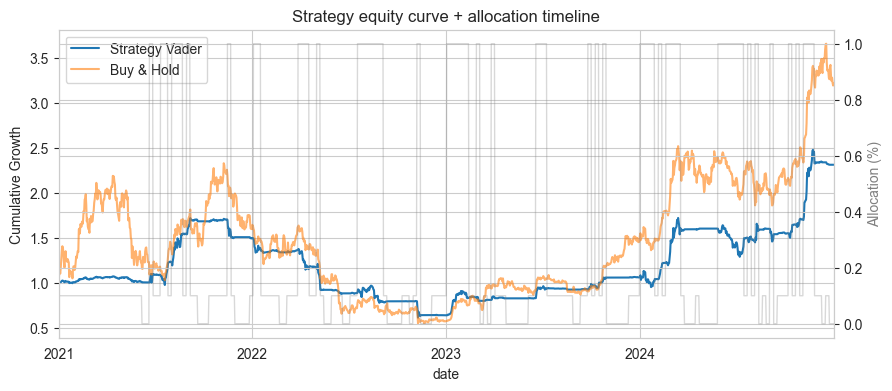

In [133]:
# single code block, directly with frozen ema

df['stratABert_ret'], df['alloc'] = build_strategy(df, best_span, return_alloc=True)
df['bh_ret'] = df['ret']

# performance table
def stats(label, r):
    return pd.Series({
        'Total Ret': cum_curve(r).iloc[-1] - 1,
        'Ann Vol': r.std()*np.sqrt(SHARPE_DAYS),
        'Sharpe': ann_sharpe(r),
        'Max DD': max_drawdown(r)
    }, name=label)

is_mask  = df.index <= TRAIN_END
oos_mask = df.index >  TRAIN_END

table = pd.concat({
    'Full':  pd.concat([stats('Strategy', df['stratABert_ret']),
                        stats('Buy&Hold', df['bh_ret'])], axis=1),
    'IS':    pd.concat([stats('Strategy', df.loc[is_mask, 'stratABert_ret']),
                        stats('Buy&Hold', df.loc[is_mask, 'bh_ret'])], axis=1),
    'OOS':   pd.concat([stats('Strategy', df.loc[oos_mask, 'stratABert_ret']),
                        stats('Buy&Hold', df.loc[oos_mask, 'bh_ret'])], axis=1)
}, axis=1).round(2)

display(table)

# equity + alloc overlay
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10,4))
cum_curve(df['stratABert_ret']).plot(ax=ax1, label='Strategy Vader')
cum_curve(df['bh_ret']).plot(ax=ax1, label='Buy & Hold', alpha=.6)
ax1.set_ylabel('Cumulative Growth')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
df['alloc'].plot(ax=ax2, color='grey', alpha=.3, linewidth=1)
ax2.set_ylabel('Allocation (%)', color='grey')
ax2.set_ylim(-0.05,1.05)
plt.title('Strategy equity curve + allocation timeline')
plt.show()

In [134]:
# save returns as csv
df[['stratAVader_ret', 'stratABert_ret', 'bh_ret']].to_csv(r'C:\Users\Leo Hubmann\Desktop\thesis\data\stratA_single_returns.csv')